In [37]:
import numpy as np
from scipy.io import loadmat

dat=loadmat(r'C:\Users\vishw\Downloads\mat2mne.mat',struct_as_record=True)

In [38]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [39]:
sfreq=dat['nfo']['fs'][0][0][0][0]
EEGdata=dat['cnt'].T
nchannels,nsamples=EEGdata.shape

channel_names=[s[0] for s in dat['nfo']['clab'][0][0][0]]

event_onsets=dat['mrk'][0][0][0]
event_codes=dat['mrk'][0][0][1]

labels=np.zeros((1,nsamples),int)
labels[0,event_onsets]=event_codes

cl_lab=[s[0] for s in dat['nfo']['classes'][0][0][0]]
cl1=cl_lab[0]
cl2=cl_lab[1]

#digitized electrode positions
xpos=dat['nfo']['xpos']
ypos=dat['nfo']['ypos']

nclasses=len(cl_lab)
nevents=len(event_onsets)

In [40]:
print('shape of EEG:',EEGdata.shape)
print('Sample rate:',sfreq)
print('no. of channels:',nchannels)
print('channel names:',channel_names)
print('no. of events:',len(event_onsets))
print('event codes:',np.unique(event_codes))
print('class labels:',cl_lab)
print('number of classes:',nclasses)

shape of EEG: (59, 190594)
Sample rate: 100
no. of channels: 59
channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
no. of events: 1
event codes: [-1  1]
class labels: ['left', 'foot']
number of classes: 2


In [41]:
#dictionary to dtore trials,each class gets an entry
trials={}

#the time window to extract for each trial,here 0.5--2.5 seconds
win=np.arange(int(0.5*sfreq),int(2.5*sfreq))

#length of the time window
nsamples=len(win)

# loop over the classes(right,left)
for cl,code in zip(cl_lab,np.unique(event_codes)):

    #extract the onsets of the classes
    cl_onsets=event_onsets[event_codes==code]
    #allocate memory for the trials
    trials[cl]=np.zeros((nchannels,nsamples,len(cl_onsets)))
    #extract each trial
    for i,onset in enumerate(cl_onsets):
        trials[cl][:,:,i]=EEGdata[:,win+onset]

#the dimensionality of the data (channels x time x trials)
print('shape of trials[cl1]:',trials[cl1].shape)
print('shape of trials[cl2]:',trials[cl2].shape)

shape of trials[cl1]: (59, 200, 100)
shape of trials[cl2]: (59, 200, 100)


In [42]:
left_hand=np.rollaxis(trials[cl1],2,0)
right_hand=np.rollaxis(trials[cl2],2,0)

In [43]:
left_hand.shape

(100, 59, 200)

In [44]:
right_hand.shape

(100, 59, 200)

In [45]:
data=np.concatenate([left_hand,right_hand])

In [46]:
Y=np.concatenate([-np.ones(left_hand.shape[0]),
                  np.ones(right_hand.shape[0])])

## Create MNE Structure

In [47]:
import mne

In [48]:
n_channels=59

#initialize an info structure
info=mne.create_info(
    ch_names=channel_names,
    ch_types=['eeg']*nchannels,
    sfreq=sfreq)
print('Event created:',info)

Event created: <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [49]:
xpos=dat['nfo']['xpos'][0][0]
ypos=dat['nfo']['ypos'][0][0]

In [50]:
layout_pos=np.concatenate([xpos,ypos],axis=1)
layout_pos

array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [51]:
layout=mne.channels.generate_2d_layout(
    xy=layout_pos,
    ch_names=channel_names,
    name='EEG custom layout',)

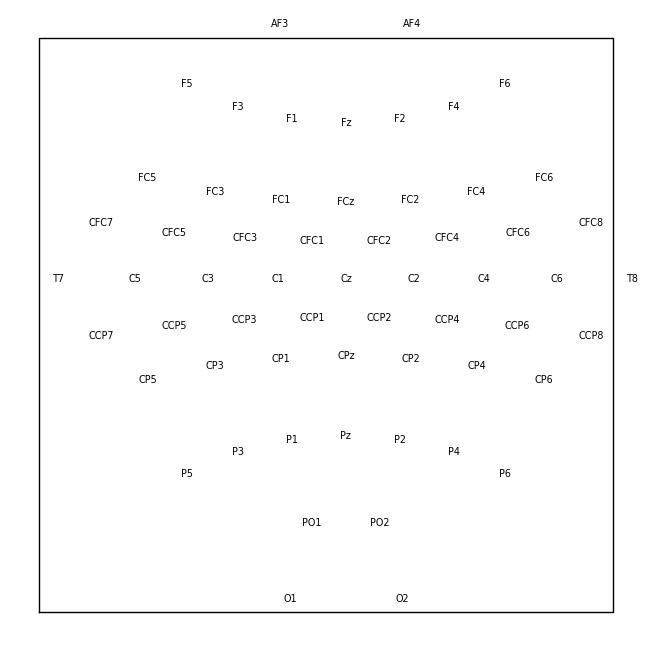

In [52]:
layout.plot();

## MNE events

In [53]:
## the events array should contain the following information [sample onsets,zeros,labels]

In [54]:
event_id=dict(left=-1,right=1)

In [55]:
#create an event matrix:events with alternating event codes
eventLength=Y.shape[0]
ev=[i*sfreq*3 for i in range(eventLength)]

events=np.column_stack((np.array(ev,dtype=int),
                        np.zeros(eventLength,dtype=int),
                        np.array(Y,dtype=int)))

In [56]:
events

array([[    0,     0,    -1],
       [  300,     0,    -1],
       [  600,     0,    -1],
       [  900,     0,    -1],
       [ 1200,     0,    -1],
       [ 1500,     0,    -1],
       [ 1800,     0,    -1],
       [ 2100,     0,    -1],
       [ 2400,     0,    -1],
       [ 2700,     0,    -1],
       [ 3000,     0,    -1],
       [ 3300,     0,    -1],
       [ 3600,     0,    -1],
       [ 3900,     0,    -1],
       [ 4200,     0,    -1],
       [ 4500,     0,    -1],
       [ 4800,     0,    -1],
       [ 5100,     0,    -1],
       [ 5400,     0,    -1],
       [ 5700,     0,    -1],
       [ 6000,     0,    -1],
       [ 6300,     0,    -1],
       [ 6600,     0,    -1],
       [ 6900,     0,    -1],
       [ 7200,     0,    -1],
       [ 7500,     0,    -1],
       [ 7800,     0,    -1],
       [ 8100,     0,    -1],
       [ 8400,     0,    -1],
       [ 8700,     0,    -1],
       [ 9000,     0,    -1],
       [ 9300,     0,    -1],
       [ 9600,     0,    -1],
       [ 9

In [57]:
#The time window(in samples) to extract for each trial,here 0.5--2.5 seconds
tmin=0.5

#create the :class: mne.EpochsArray object
epochs=mne.EpochsArray(data,info,events,tmin,event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


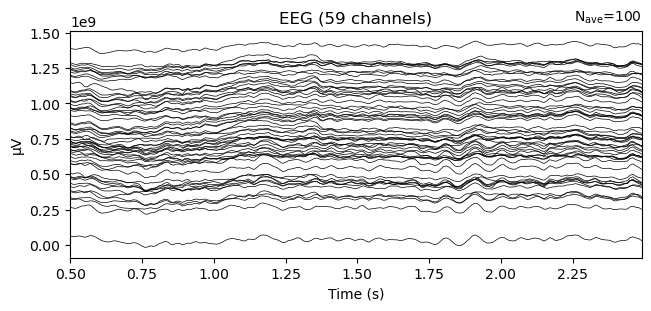

In [58]:
epochs['left'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\vishw\AppData\Local\Temp\ipykernel_23352\2204970765.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd();
C:\Users\vishw\AppData\Local\Temp\ipykernel_23352\2204970765.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd();
C:\Users\vishw\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


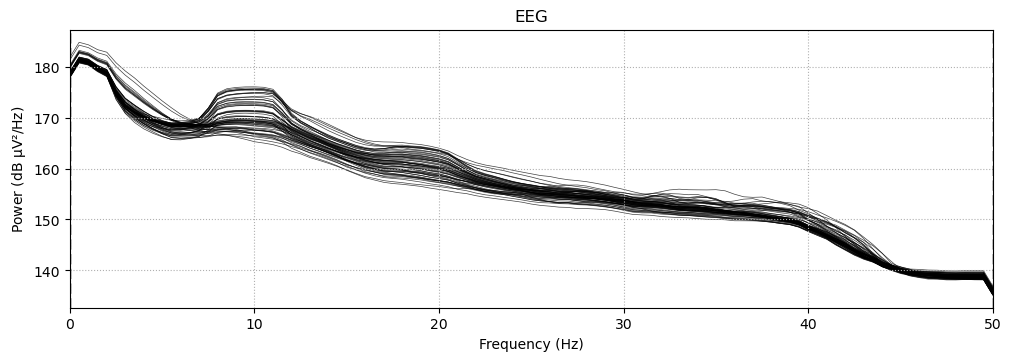

In [59]:
epochs.plot_psd();

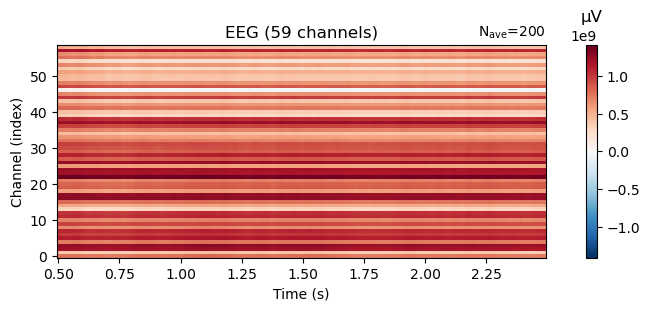

In [60]:
epochs.average().plot_image();

In [61]:
epochs.filter(l_freq=8,h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    3.6s finished


Number of events,200
Events,left: 100right: 100
Time range,0.500 – 2.490 s
Baseline,off


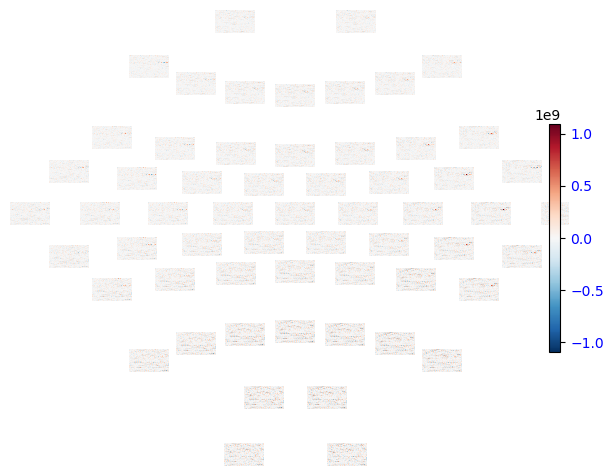

In [62]:
epochs.plot_topo_image(layout=layout,fig_facecolor='w',font_color='b');

## evoked

In [63]:
left=epochs['left'].average()
left

Condition,left
Data kind,average
Timepoints,200 samples
Channels,59 channels
Number of averaged epochs,100
Time range (secs),0.5 – 2.49
Baseline (secs),off


In [64]:
right=epochs['right'].average()
right

Condition,right
Data kind,average
Timepoints,200 samples
Channels,59 channels
Number of averaged epochs,100
Time range (secs),0.5 – 2.49
Baseline (secs),off


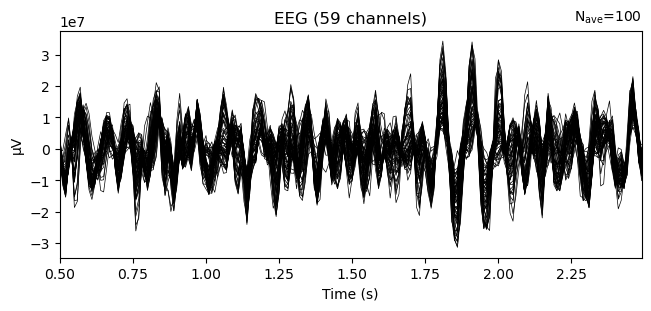

In [66]:
left.plot();

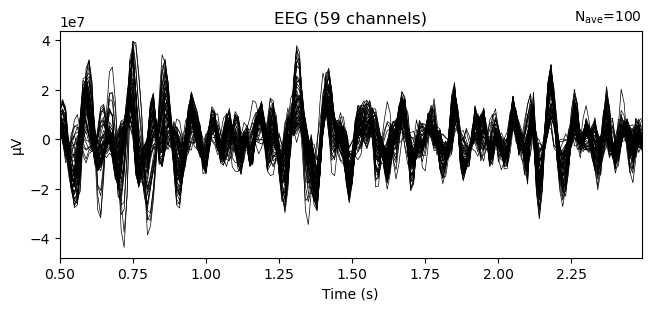

In [67]:
right.plot();

In [73]:
left.plot_topomap();

RuntimeError: No digitization points found.

In [75]:
left.plot_sensors(show_names=True);

RuntimeError: No valid channel positions found